In [1]:
from mario_replays.load_data import load_replay_data
import os
import pandas as pd

sourcedata = '../../mario_learning.behavior/sourcedata/'

In [2]:
#clips_df = load_replay_data(os.path.join(sourcedata, 'scene_clips'), type='metadata')
#clips_variables = load_replay_data(os.path.join(sourcedata, 'scene_clips'), type='variables')

repetitions_df = load_replay_data(os.path.join(sourcedata, 'replays'), type='metadata')
repetitions_variables = load_replay_data(os.path.join(sourcedata, 'replays'), type='variables')


In [22]:
from mario_scenes.load_data import load_background_images
from mario_scenes.load_data import load_scenes_info

level_backgrounds = load_background_images(level='level')
scene_backgrounds = load_background_images(level='scene')
scenes_info = load_scenes_info(format='df')

In [4]:
level_backgrounds['w1l1'].size

(3167, 224)

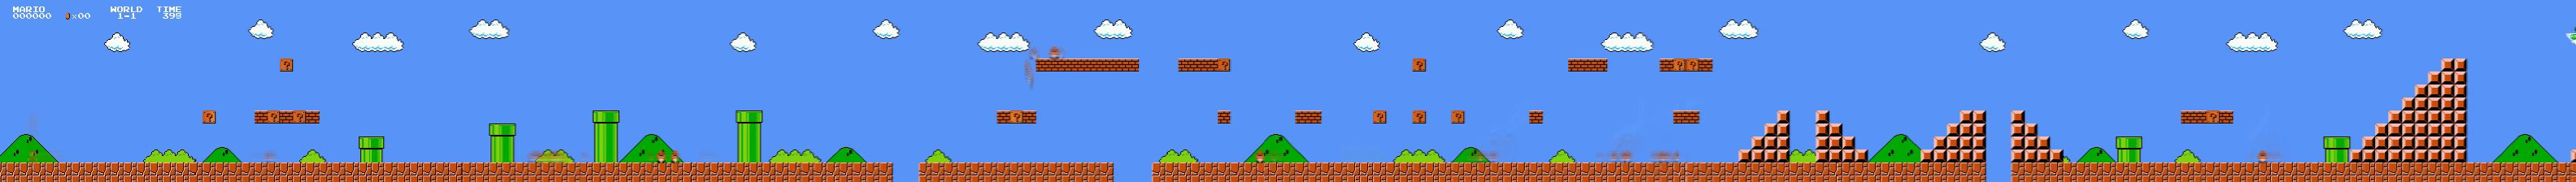

In [5]:
level_backgrounds['w1l1']

,Subject,World,Level,Duration,Cleared,ScoreGained,X_Traveled,Lives_lost,Hits_taken,Enemies_killed,...,StartFrame,EndFrame,TotalFrames,Bk2Filepath,GameName,LevelFullName,IndexInRun,IndexGlobal,IndexLevel,Phase
0,01,2,1,4.483333,False,50,82,1,1,0,...,1814,2082,5702,sub-01/ses-001/gamelogs/sub-01_ses-001_task-ma...,SuperMarioBros-Nes,w2l1,5,38,5,discovery
1,01,1,2,2.450000,True,0,174,0,0,0,...,1127,1273,3098,sub-01/ses-001/gamelogs/sub-01_ses-001_task-ma...,SuperMarioBros-Nes,w1l2,5,16,5,discovery
2,01,1,2,3.083333,True,10,250,0,0,0,...,840,1024,3090,sub-01/ses-001/gamelogs/sub-01_ses-001_task-ma...,SuperMarioBros-Nes,w1l2,1,12,1,discovery
3,01,1,3,3.566667,True,0,159,0,0,0,...,1164,1377,2597,sub-01/ses-001/gamelogs/sub-01_ses-001_task-ma...,SuperMarioBros-Nes,w1l3,8,29,8,discovery
4,01,1,3,6.066667,False,0,156,1,1,0,...,2164,2527,2528,sub-01/ses-001/gamelogs/sub-01_ses-001_task-ma...,SuperMarioBros-Nes,w1l3,1,22,1,discovery
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56136,06,8,2,0.916667,True,0,135,0,0,0,...,3767,3821,6729,sub-06/ses-025/gamelogs/sub-06_ses-025_task-ma...,SuperMarioBros-Nes,w8l2,2,608,27,practice
56137,06,5,2,14.316667,True,100,190,0,0,0,...,2751,3609,8074,sub-06/ses-025/gamelogs/sub-06_ses-025_task-ma...,SuperMarioBros-Nes,w5l2,1,585,30,practice
56138,06,8,2,2.033333,True,0,162,0,0,0,...,721,842,6729,sub-06/ses-025/gamelogs/sub-06_ses-025_task-ma...,SuperMarioBros-Nes,w8l2,2,608,27,practice
56139,06,5,3,2.416667,True,0,129,0,0,0,...,133,277,5862,sub-06/ses-025/gamelogs/sub-06_ses-025_task-ma...,SuperMarioBros-Nes,w5l3,2,591,26,practice


In [ ]:
import numpy as np
from scipy.interpolate import interp1d

from PIL import Image, ImageDraw, ImageFont
import numpy as np
import matplotlib.pyplot as plt


def get_traces(subject, level, variables_df, scene=None):
    subj_repvars = repetitions_variables[repetitions_variables['subject'] == subject]
    level_subj_repvars = subj_repvars[subj_repvars['level'] == level]

    x_list = []
    y_list = []
    order_list = []
    for idx, repvars in level_subj_repvars.iterrows():
        repvars['player_x_pos'] = [
            hi * 256 + lo for hi, lo in zip(repvars['player_x_posHi'], repvars['player_x_posLo'])
        ]
        #repvars['corrected_player_y_pos'] = 
        #np.asarray([float(d["player_y_pos"])+24-(1-d["player_y_screen_pos"])*256 for d in rep_data[1]])
        pstate = np.asarray(repvars['player_state'])
        y_pos= np.asarray([x+24-(1-repvars['player_y_screen'][idx])*256 for idx, x in enumerate(repvars['player_y_pos'])])
        y_pos_masked = np.ma.masked_where(pstate==0, y_pos)
        y_list.append(list(y_pos_masked))
        x_list.append(repvars['player_x_pos'])
        #y_list.append([x+24-(1-repvars['player_y_screen'][idx])*256 for idx, x in enumerate(repvars['player_y_pos'])])
        
        #corrected_y = correct_player_y_positions(repvars['player_y_pos'], repvars['player_state'])
        #y_list.append(y_list)
        fname = repvars['filename'].split('/')[-1].split('.')[0]
        ses = fname.split('_')[1].split('-')[1]
        rep = fname.split('_')[-1].split('-')[1]
        order_list.append(int(f'{ses}{rep}'))
    return x_list, y_list, order_list


def draw_traces_on_image(image, x_values_list, y_values_list, order_values, line_size=2, ticks=5):
    """
    Draws traces on an image using ordinal order for coloring, and adds a vertical colormap with tick marks and labels on the left.

    Parameters:
    -----------
    image : PIL.Image
        The image on which to draw.

    x_values_list : list of lists
        A list containing N lists of x-values.

    y_values_list : list of lists
        A list containing N lists of y-values.

    order_values : list
        A list of N values whose ordinal position defines the trace color.

    line_size : int
        Thickness of the lines to be drawn.

    ticks : int
        Number of tick marks and labels on the colormap.

    Returns:
    --------
    PIL.Image
        The new image with traces and a ranked colormap.
    """
    assert len(x_values_list) == len(y_values_list) == len(order_values), "Mismatched input lengths."

    width, height = image.size
    colorbar_width = 20
    label_margin = 35
    margin_ratio = 0.05  # 5% top and bottom margin
    top_margin = int(height * margin_ratio)
    bottom_margin = int(height * margin_ratio)
    colorbar_height = height - top_margin - bottom_margin

    new_img = Image.new("RGB", (width + colorbar_width + label_margin, height), "white")
    new_img.paste(image, (colorbar_width + label_margin, 0))
    draw = ImageDraw.Draw(new_img)

    N = len(order_values)
    colormap = plt.get_cmap('viridis')

    # Compute rank order of traces
    sorted_indices = np.argsort(order_values)
    ranked_orders = [None] * N
    for rank, idx in enumerate(sorted_indices):
        ranked_orders[idx] = rank

    # Normalize to [0, 1] colormap
    norm_orders = np.linspace(0, 1, N)

    # Draw colorbar within vertical bounds
    for i in range(colorbar_height):
        t = 1 - (i / (colorbar_height - 1))
        y = top_margin + i
        color = tuple(int(c * 255) for c in colormap(t)[:3])
        draw.line([(label_margin, y), (label_margin + colorbar_width - 1, y)], fill=color)

    # Draw tick marks and labels on the left
    try:
        font = ImageFont.truetype("arial.ttf", 12)
    except IOError:
        font = ImageFont.load_default()

    for i in range(ticks):
        t = i / (ticks - 1)
        y = top_margin + int(t * (colorbar_height - 1))
        rank = int(round((1 - t) * (N - 1)))
        label = str(rank)

        # Tick mark
        tick_x0 = label_margin - 5
        tick_x1 = label_margin - 1
        draw.line([(tick_x0, y), (tick_x1, y)], fill="black", width=1)

        # Label
        draw.text((2, y - 6), label, fill="black", font=font)

    # Draw traces with rank-based color
    for idx, (x_vals, y_vals) in enumerate(zip(x_values_list, y_values_list)):
        rank = ranked_orders[idx]
        color = tuple(int(c * 255) for c in colormap(norm_orders[rank])[:3])
        points = list(zip(x_vals, y_vals))
        if len(points) < 2:
            continue
        for i in range(len(points) - 1):
            p1 = (x_vals[i] + colorbar_width + label_margin, y_vals[i])
            p2 = (x_vals[i + 1] + colorbar_width + label_margin, y_vals[i + 1])
            draw.line([p1, p2], fill=color, width=line_size)

    return new_img


x_list, y_list, order_list = get_traces('01', 'w8l2', repetitions_variables)

In [18]:
repetitions_variables.keys()

Index(['filename', 'level', 'subject', 'session', 'repetition', 'actions',
       'powerup_yes_no', 'moving_direction', 'player_x_posHi', 'score',
       'powerup_appear', 'powerstate', 'player_y_screen', 'player_y_pos',
       'player_x_posLo', 'star_timer', 'enemy_drawn19', 'xscrollHi',
       'enemy_kill34', 'enemy_kill31', 'enemy_kill30', 'enemy_kill32',
       'enemy_drawn17', 'world', 'fireball_counter', 'scrolling', 'stage',
       'time', 'walk_animation', 'xscrollLo', 'enemy_drawn18', 'enemy_drawn16',
       'enemy_drawn15', 'coins', 'enemy_kill33', 'area', 'jump_airborne',
       'levelHi', 'levelLo', 'player_sprite', 'lives', 'enemy_kill35',
       'level_layout', 'player_state', 'B', 'null', 'SELECT', 'START', 'UP',
       'DOWN', 'LEFT', 'RIGHT', 'A'],
      dtype='object')

/home/hyruuk/mambaforge/envs/mario_learning/lib/python3.10/site-packages/PIL/ImageDraw.py:246: UserWarning: Warning: converting a masked element to nan.
  self.draw.draw_lines(xy, ink, width)


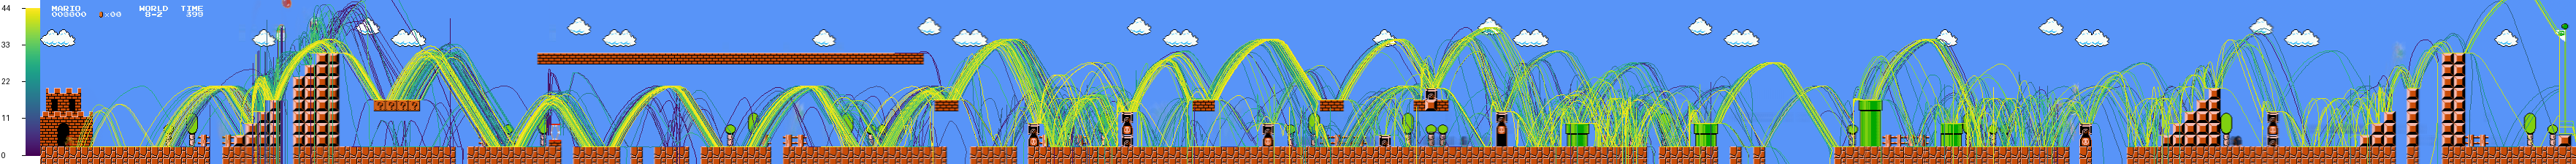

In [ ]:





draw_traces_on_image(level_backgrounds['w8l2'], x_list, y_list, order_list, line_size=1)

/home/hyruuk/mambaforge/envs/mario_learning/lib/python3.10/site-packages/PIL/ImageDraw.py:246: UserWarning: Warning: converting a masked element to nan.
  self.draw.draw_lines(xy, ink, width)


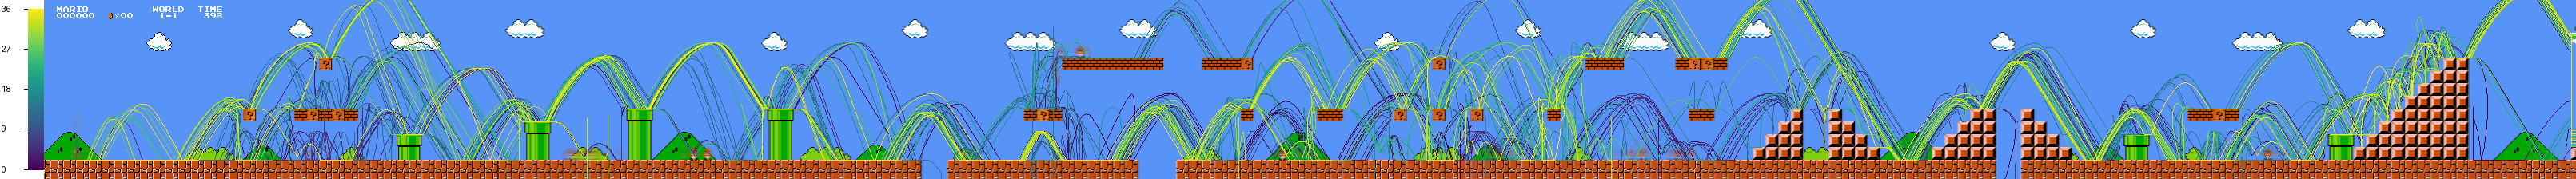

In [ ]:
outputfolder = '../outputdata/figures/traces'
os.makedirs(outputfolder, exist_ok=True)

for subject in ['01', '02', '03', '05', '06']:
    level_backgrounds = load_background_images(level='level')
    for level in level_backgrounds.keys():
        x_list, y_list, order_list = get_traces(subject, level, repetitions_variables)
    
        draw_traces_on_image(level_backgrounds[level], x_list, y_list, order_list, line_size=1)
        level_backgrounds[level].save(os.path.join(outputfolder, f'sub-{subject}_level-{level}_traces.png'))

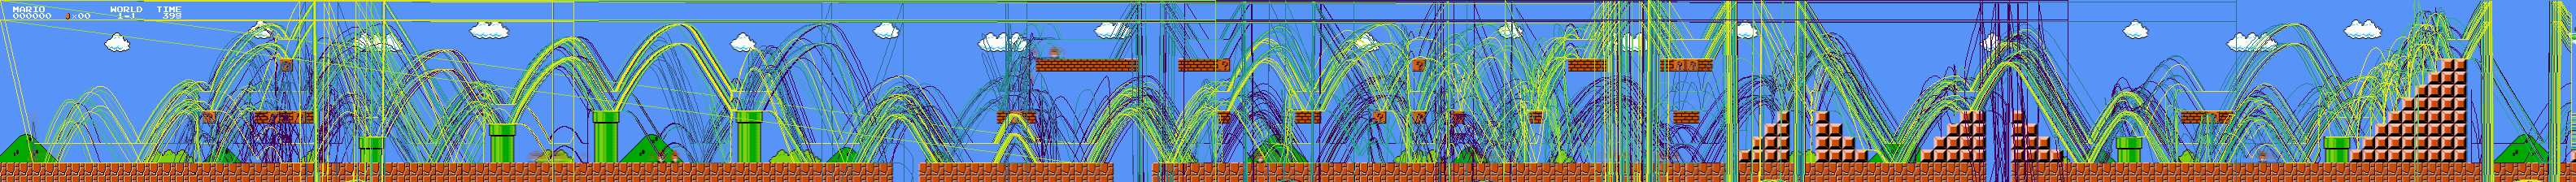